# **Plant Leaf Disease Detection using CNNs**

---

## **1. Business Objective**

Crop diseases are a major threat to food security, but their rapid identification remains difficult in many parts of the world due to the lack of the necessary infrastructure. The combination of increasing global smartphone penetration and recent advances in computer vision made possible by deep learning has paved the way for disease diagnosis. Every disease, pest, and deficiency leaves behind a specific pattern. 


The objective of this project is to apply Machine Learning Algorithms to identify the plant leaf diseases for an input image.

## **2. Data Collection**

We have used the plant village dataset. The PlantVillage dataset consists of 61,486 healthy and unhealthy leaf images divided into 39 categories by species and disease. The data in form of images was provided by:

Link: https://data.mendeley.com/datasets/tywbtsjrjv/1

In [1]:
# Connecting to Google drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
mlp.rcParams["figure.figsize"] = (25,5)
plt.style.use('seaborn')

In [41]:
# Importing the ML/DL libraries

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split       

from tensorflow.keras.applications import InceptionResNetV2, inception_resnet_v2, Xception, xception

from PIL import Image
import cv2

In [5]:
# Importing few helper libraries

import sys 
import os
import random
import shutil
import zipfile
from glob import glob
from datetime import datetime
from tqdm import tqdm

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [6]:
# Loading the dataset

# Path for Drive and Tmp forlder in Colab
DRIVE_DIR = "/content/drive/MyDrive/Colab Datasets/Plant Disease Classification"
TMP_DIR = "/tmp"
zip_file_name = "Plant Leaf Diseases Dataset.zip"

# File path for zip file in the drive
source_file_path = os.path.join(DRIVE_DIR, zip_file_name)

# File path for zip file in the tmp 
dest_file_path = os.path.join(TMP_DIR, zip_file_name)

print("Copying from drive to temp folder...")
# Copying the zip file from source to destination
shutil.copyfile(source_file_path, dest_file_path)

print("Extracting all images...")
zip_ref = zipfile.ZipFile(dest_file_path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print("Done..")

Copying from drive to temp folder...
Extracting all images...
Done..


In [7]:
# All images have been un-zipped in the tmp folder.
# There are sub-folders for image sets

unzip_folder_name = "Plant_leave_diseases_dataset_with_augmentation"
data_root = os.path.join(TMP_DIR, unzip_folder_name)

In [8]:
# Define function to load data files from the path

def load_dataset(path):
    data = load_files(path)
    image_path = np.array(data["filenames"])
    class_name = np.array(data["target_names"])
    labelled_targets = np.array(data["target"])
    ohe_targets = np_utils.to_categorical(np.array(data["target"]), len(np.unique(np.array(data["target"]))))

    return image_path, labelled_targets , ohe_targets, class_name 

In [9]:
# Load data files

image_path, labelled_class, ohe_class, class_name = load_dataset(data_root)

In [10]:
# Checking the basic details about the data

print("The total number of images in the dataset is : ", len(image_path))
print("The number of class labels is : ", len(class_name))

print("\nThe list of class labels is : \n", class_name)
value_counts = np.unique(labelled_class, return_counts=True)
print("\nThe class labels are : \n", value_counts[0])
print("\nThe value counts for each class labels is : \n", value_counts[1])

The total number of images in the dataset is :  61486
The number of class labels is :  39

The list of class labels is : 
 ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Background_without_leaves' 'Blueberry___healthy'
 'Cherry___Powdery_mildew' 'Cherry___healthy'
 'Corn___Cercospora_leaf_spot Gray_leaf_spot' 'Corn___Common_rust'
 'Corn___Northern_Leaf_Blight' 'Corn___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'To

Observations:

1. There are 60K+ images in the dataset.
2. There are 39 different classes with disease class and healthy class for various plant leaves.

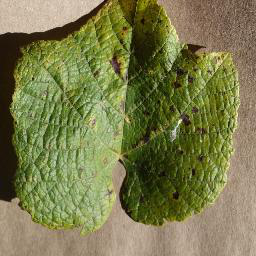

In [11]:
# Checking a random image

im = Image.open(random.choice(image_path))  
im

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape (samples, height, width, channels).

In [12]:
# Convert Image into 4D Tensors using their paths

def ConvertImageTo4DTensor(img_path):
    # Load RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def GetImageTensorsUsingImageLocation(img_paths):
    list_of_tensors = [ConvertImageTo4DTensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [13]:
# Creating the train, val and test set of indexes to divide the dataset using stratified train_test_split

X = range(0, len(labelled_class))
y = labelled_class

X_del, X_sample, y_del, y_sample = train_test_split(X, y, test_size=0.20, stratify=y)

In [14]:
# Load train, test, and validation datasets

del_image_path, del_labelled_class, del_ohe_class  = image_path[X_del], labelled_class[X_del], ohe_class[X_del]

In [15]:
for path in del_image_path:
    os.remove(path)

Observations:

Due to computation limitations, we will be using 20 of the images of the total 60K+ images provided to us.

## **4. Model Building**

We will be using the pre-trained models trained on imagenet dataset in order to cutomize the output layers to predict different plant disease.

In [27]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS = 224, 224, 3

In [72]:
# Using the preprocess method of Xception to generate data from paths and split it for training and testing

aug = ImageDataGenerator(preprocessing_function = xception.preprocess_input, validation_split = 0.20, rescale = 1.0/255)  
batch_size = 64

training_set = aug.flow_from_directory(
                                      data_root,
                                      target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                      batch_size = batch_size,
                                      class_mode = "categorical",
                                      subset = "training"
                                      )

test_set = aug.flow_from_directory(
                                  data_root,
                                  target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                  batch_size = batch_size,
                                  class_mode = "categorical",
                                  subset = "validation"
                                  )

Found 9846 images belonging to 39 classes.
Found 2452 images belonging to 39 classes.


Observations:

We tested various models: AlexNet, VGG, ResNet50 but the newer combination of InceptionResNetV2 provides us the best training and validation accuracy.

The reason could probably be due to the fact that the newer model captures more features as compared to older models.

In [73]:
# Defining the base model

baseModel = Xception(weights = "imagenet", include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(baseModel.summary())

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [87]:
# Defining Architecture
def BuildCustomizedModel():
    
    model = Sequential([
                        baseModel,
                        # here is our custom prediction layer
                        GlobalAveragePooling2D(),
                        BatchNormalization(),
                        Dense(39, activation='softmax', name = "Xception_dense")    
                      ])
       
    # weights and biases of just our newly added layers
    baseModel.trainable = False    
    
    return model

In [88]:
model = BuildCustomizedModel()
model.compile(optimizer=Adam(learning_rate = 0.005), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
batch_normalization_631 (Bat (None, 2048)              8192      
_________________________________________________________________
Xception_dense (Dense)       (None, 39)                79911     
Total params: 20,949,583
Trainable params: 84,007
Non-trainable params: 20,865,576
_________________________________________________________________
None


In [89]:
# Defining the criteria to stop training. 
# We will stop training if validation accuracy got reached 98% after the corresponding epoch completes. 
#We are using Callback from tf.keras.callbacks to achieve this.

class myCallback(tf.keras.callbacks.Callback):
	
    def on_epoch_end(self, epoch, logs={}):      
        if(logs.get('val_accuracy') > 0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [90]:
startTime = datetime.now()
print("Training started..")

# Start training
history = model.fit(
                    training_set,
                    steps_per_epoch = training_set.samples // batch_size,
                    validation_data = test_set,
                    epochs = 30,
                    validation_steps = test_set.samples // batch_size,
                    callbacks = [callbacks],
                    verbose = 1
                    )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Training started..
Epoch 1/30
153/153 [==============================] - 50s 327ms/step - loss: 1.8872 - accuracy: 0.4692 - val_loss: 3.4676 - val_accuracy: 0.0387
Epoch 2/30
153/153 [==============================] - 48s 313ms/step - loss: 1.2814 - accuracy: 0.6282 - val_loss: 2.9064 - val_accuracy: 0.2270
Epoch 3/30
153/153 [==============================] - 49s 317ms/step - loss: 1.0678 - accuracy: 0.6884 - val_loss: 1.9731 - val_accuracy: 0.4642
Epoch 4/30
153/153 [==============================] - 48s 316ms/step - loss: 0.9544 - accuracy: 0.7195 - val_loss: 1.2286 - val_accuracy: 0.6883
Epoch 5/30
153/153 [==============================] - 48s 316ms/step - loss: 0.8562 - accuracy: 0.7460 - val_loss: 1.0130 - val_accuracy: 0.7093
Epoch 6/30
153/153 [==============================] - 48s 316ms/step - loss: 0.7966 - accuracy: 0.7606 - val_loss: 0.9634 - val_accuracy: 0.7212
Epoch 7/30
153/153 [==============================] - 48s 316ms/step - loss: 0.7338 - accuracy: 0.7765 - val_lo

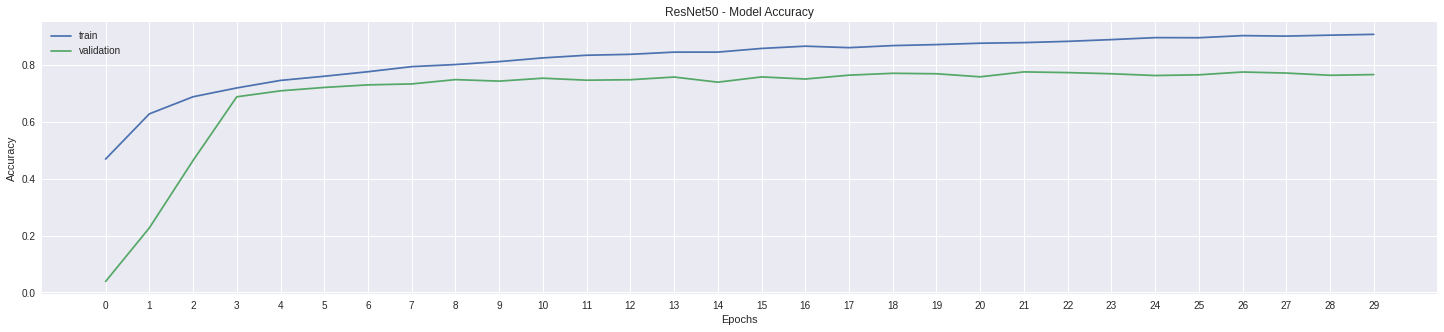

In [91]:
# Visualizing the accuracy with epochs

plt.style.use('seaborn')
figure, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("ResNet50 - Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc="upper left")
_ = plt.xticks(range(0, 30))

In [92]:
startTime = datetime.now()
print("Training started..")

# Start training
history = model.fit(
                    training_set,
                    steps_per_epoch = training_set.samples // batch_size,
                    validation_data = test_set,
                    epochs = 20,
                    validation_steps = test_set.samples // batch_size,
                    callbacks = [callbacks],
                    verbose = 1
                    )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Training started..
Epoch 1/20
153/153 [==============================] - 50s 324ms/step - loss: 0.2965 - accuracy: 0.9098 - val_loss: 0.8742 - val_accuracy: 0.7747
Epoch 2/20
153/153 [==============================] - 48s 312ms/step - loss: 0.2851 - accuracy: 0.9117 - val_loss: 0.9246 - val_accuracy: 0.7669
Epoch 3/20
153/153 [==============================] - 49s 318ms/step - loss: 0.2839 - accuracy: 0.9110 - val_loss: 0.8717 - val_accuracy: 0.7730
Epoch 4/20
153/153 [==============================] - 48s 315ms/step - loss: 0.2651 - accuracy: 0.9166 - val_loss: 0.9390 - val_accuracy: 0.7759
Epoch 5/20
153/153 [==============================] - 48s 316ms/step - loss: 0.2896 - accuracy: 0.9092 - val_loss: 0.9284 - val_accuracy: 0.7726
Epoch 6/20
153/153 [==============================] - 48s 317ms/step - loss: 0.2558 - accuracy: 0.9213 - val_loss: 0.9570 - val_accuracy: 0.7656
Epoch 7/20
153/153 [==============================] - 48s 316ms/step - loss: 0.2473 - accuracy: 0.9231 - val_lo

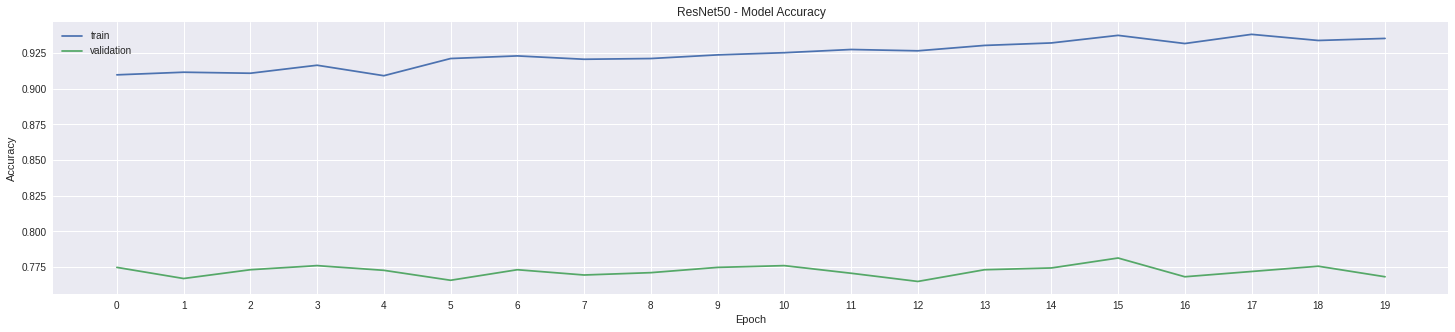

In [93]:
# Visualizing the accuracy with epochs

plt.style.use('seaborn')
figure, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("ResNet50 - Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
_ = plt.xticks(range(0, 20))

Observations:

We tried a lots of model ResNet50, Inception and InceptionResNetV2 with various Dropout values, but the final model that was giving us the better results was Xception.

We trained the pre-trained Xception model with custom output layer to train on the plant leaf images.

After 30 epochs, the Training Accuracy reached to 90% with Validation accuracy of 76%.

We trained the model for 20 more epochs where the Training accuracy reached 93% with validation accuracy staying the same at 76%.

In [94]:
# Save the model to file

model.save(DRIVE_DIR + "/XceptionCustom.h5")

In [115]:
# Extracting class labels and names

dict_labels = training_set.class_indices
class_names = list(dict_labels.keys())
class_labels = list(dict_labels.values())

In [172]:
# Predict Label

# Function to show 4 random images of the specific plant disease
def ShowNSimilarImages(str_disease, n=4):

    fig, ax = plt.subplots(1, n, figsize=(25, 8))
    img_idx =  np.flatnonzero(np.core.defchararray.find(image_path[X_sample], str_disease) != -1)
    for i, idx in enumerate(np.random.choice(img_idx, 4)):
        plt.subplot(1, n, i+1)
        img = cv2.imread(image_path[X_sample][idx])
        plt.imshow(img)

def PredictLabels(imagepath, model):

    print("Loading image")
    img = cv2.imread(imagepath)
    plt.imshow(img)
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img * 1.0/255

    print("Predicting output")
    prediction = model.predict(img)
    prediction_flatten = prediction.flatten()
    max_val_index = np.argmax(prediction_flatten)
    result = class_name[max_val_index]

    text = "It looks like a bit of a " + result 
    # output text
    print(text + ".")

    # output 4 sample images of the recognized dog breed:
    ShowNSimilarImages(result)

Actual image name :  Grape___healthy
Prediction.......
Loading image
Predicting output
It looks like a bit of a Grape___healthy.


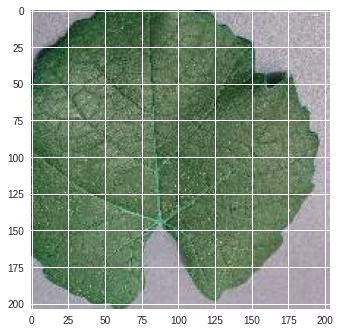

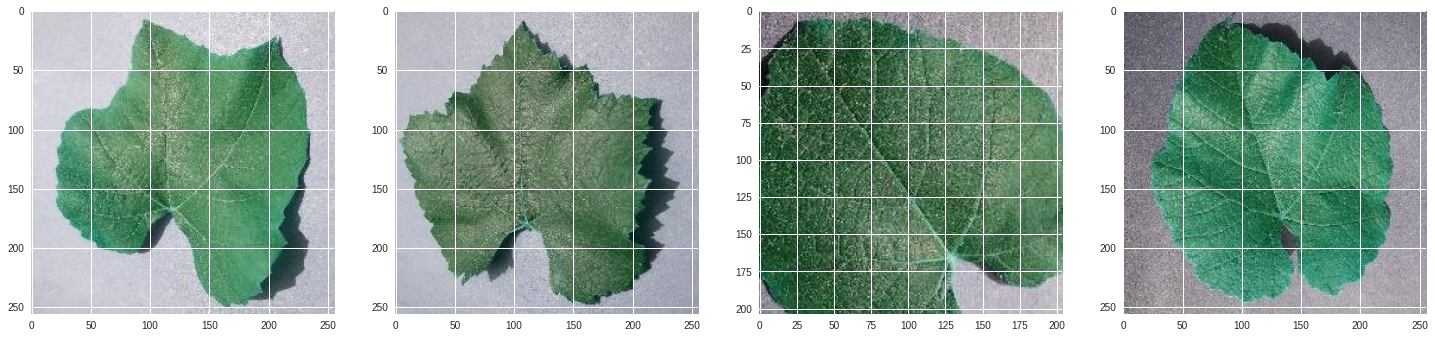

In [176]:
# Testing random image

idx = random.choice(X_sample)
test_im_path = image_path[idx]
print("Actual image name : ", test_im_path.split("/")[3])

print("Prediction.......")
PredictLabels(test_im_path, model)

Actual image name :  Peach___Bacterial_spot
Prediction.......
Loading image
Predicting output
It looks like a bit of a Peach___Bacterial_spot.


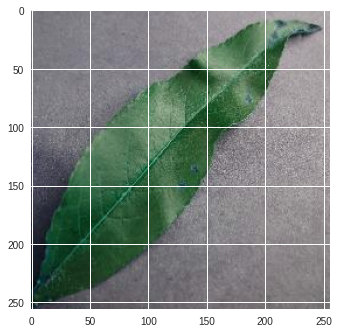

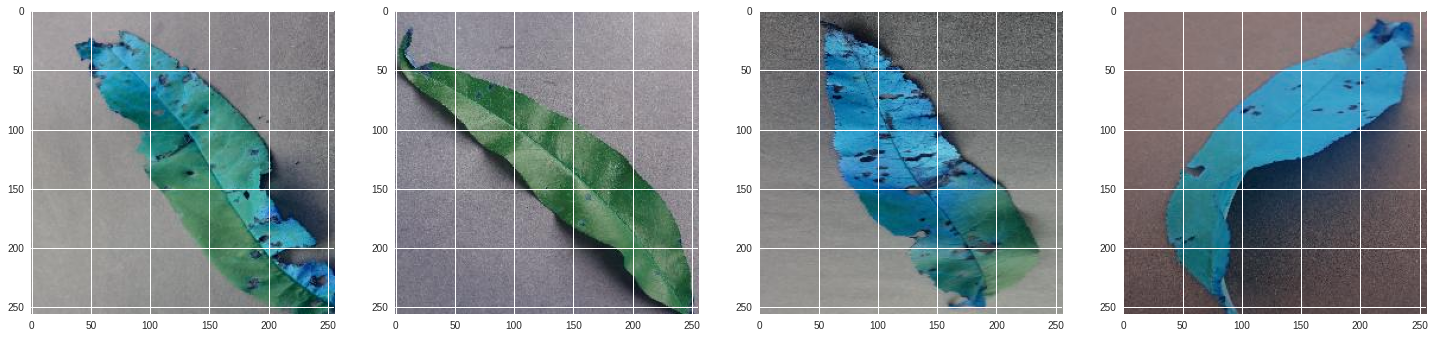

In [186]:
# Testing random image

idx = random.choice(X_sample)
test_im_path = image_path[idx]
print("Actual image name : ", test_im_path.split("/")[3])

print("Prediction.......")
PredictLabels(test_im_path, model)

In [187]:
import json

labels = {
    "Class_Name" : class_names,
    "Class_Labels" : class_labels,
}

with open(DRIVE_DIR + "/labels.json", "w") as f:
    f.write(json.dumps(labels))

## **5. Conclusion**

In this project we used various pre-trained model for the development of an app for the identification of various plant leaf disease, and we achieved our best results with the application of a transfer learning model. We achieved an validation accuracy of 75% in our tests using XceptionNet Model. 

However, we still see several options to further improve our algorithm in the future:
  1. We could gather more training data as due to compatational capacity, we just used 20% of it.
  2. We could add more layers to make our model more complex and hopefully more powerful.
  3. We could extend our training time and add more epochs to the training.

But all in all, the accuracy levels from our tests, along with the tests with specific sample images, suggest that we already have a serious model we could work with in a real app.